In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gpflow 

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm

import gpflow

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
import seaborn as sns

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-10-05 11:57:55.195925: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 11:57:55.200694: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 11:57:55.264137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 11:57:57.057952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
var = 'Cooling'
file = 'Intermediate_outputs/TOA_forcings.csv'


In [15]:
matplotlib.rcParams.update({'font.size': 15})

In [3]:
DF = pd.read_csv(file)
DF = DF[DF['Seasonal']=='No']
inputs = DF[['Injection_latitude', 'Injection_altitude']].values
outputs = DF[var].values.reshape(len(DF), 1)

In [4]:
def get_model(inputs, outputs):
    kernel = gpflow.kernels.Matern52(lengthscales=[2, 1])
    #kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.9,1.1])
    model = gpflow.models.GPR(
        (inputs, outputs), kernel=deepcopy(kernel), noise_variance=1e-3
    )
    
    gpflow.set_trainable(model.likelihood, True)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

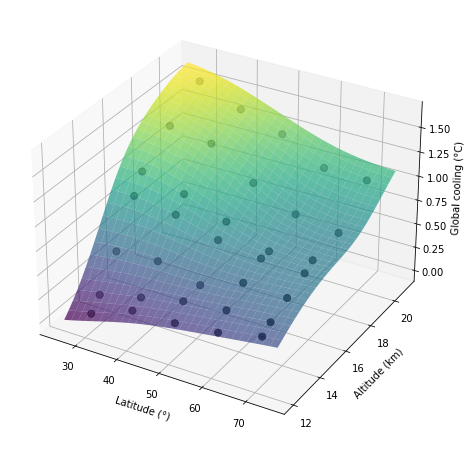

In [5]:
model = get_model(inputs, outputs)

n_grid = 30
Xplot1, Xplot2 = np.meshgrid(np.linspace(25, 75, n_grid), np.linspace(12, 21, n_grid))
Xplot = np.stack([Xplot1, Xplot2], axis=-1)
Xplot = Xplot.reshape([n_grid ** 2, 2])

f_mean, _ = model.predict_f(Xplot, full_cov=False)
f_mean = f_mean.numpy().reshape((n_grid, n_grid))

fig, ax = plt.subplots(nrows=1, ncols=1, 
                       subplot_kw={"projection": "3d"},
                       figsize=(8, 8))
ax.plot_surface(Xplot1, Xplot2, f_mean, cmap='viridis', alpha=0.7)
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Latitude (°)')
ax.set_zlabel('Global cooling (°C)')
ax.scatter(inputs[:, 0], inputs[:, 1], outputs[:, 0], s=50, c="black")
#plt.savefig('Figures/{}_surface_GPmod.jpg'.format(var), dpi=400)

In [6]:
### test model using LOOCV:

true, predicted, errors = [], [], []

for i in range(len(inputs)):
    inputs_LOO = np.delete(inputs, i, axis=0)
    outputs_LOO = np.delete(outputs, i, axis=0)
    
    model = get_model(inputs_LOO, outputs_LOO)
    
    n_grid = 1
    Xplot1, Xplot2 = np.meshgrid([inputs[i][0]], [inputs[i][1]])
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])
    
    y_mean, y_var = model.predict_y(Xplot, full_cov=False)
    y_mean = y_mean.numpy().reshape((n_grid, n_grid))
    y_var = y_var.numpy().reshape((n_grid, n_grid))
    true.append(outputs[i].item())
    predicted.append(y_mean.item())
    errors.append(1.96*np.sqrt(y_var.item())) # 95% confidence interval, assuming Gaussian

true_errors = []
for i in range(len(true)):
    true_errors.append(np.absolute(predicted[i] - true[i]))


i=0
outside_error = []
outside_error_indeces = []
for e in true_errors:
    if e > errors[i]:
        outside_error.append('red')
        outside_error_indeces.append(i)
    else:
        outside_error.append('blue')
    i=i+1

2024-10-05 11:58:07.393858: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Expected number of red points:
1.75
Red locations:
[array([50.625, 14.1  ])]
[0.14426488775900048]


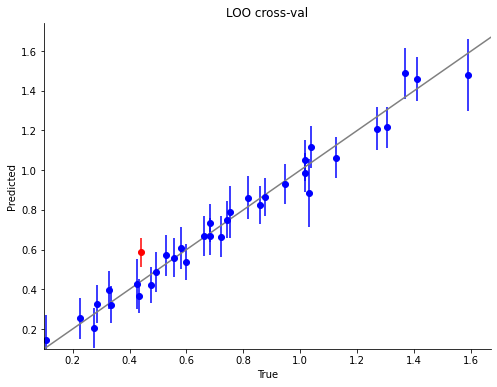

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

predicted_inside_error, predicted_outside_error = [], []
true_inside_error, true_outside_error = [], []
errors_inside_error, errors_outside_error = [], []

for i in range(len(true)):
    if i not in outside_error_indeces:
        predicted_inside_error.append(predicted[i])
        true_inside_error.append(true[i])
        errors_inside_error.append(errors[i])
    else:
        predicted_outside_error.append(predicted[i])
        true_outside_error.append(true[i])
        errors_outside_error.append(errors[i])
    
ax.errorbar(true_inside_error, predicted_inside_error, yerr=errors_inside_error, fmt='o', color='blue')
ax.errorbar(true_outside_error, predicted_outside_error, yerr=errors_outside_error, fmt='o', color='red')
ax.axline((0, 0), slope=1, c='gray')
ax.set_xlim(0.1,)
ax.set_ylim(0.1,)
ax.set_title('LOO cross-val')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('Figures/Supp/GP_LOOCV.jpg', dpi=300)

print('Expected number of red points:')
print(0.05*len(inputs))
print('Red locations:')
print([inputs[i] for i in outside_error_indeces])
print([predicted[i] - true[i] for i in outside_error_indeces])

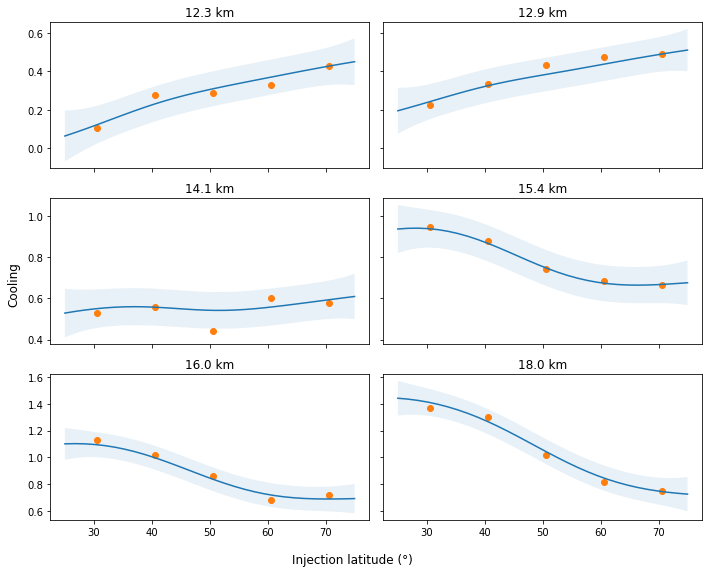

In [8]:
### plot altitude slices: 
fig, axs = plt.subplots(3, 2, figsize=(10, 8), 
                       sharex=True, sharey='row')
i=0

for altitude in DF['Injection_altitude'].sort_values().unique()[0:-1]:
    ax = axs.flatten()[i]
    n_grid = 30
    Xplot1, Xplot2 = np.meshgrid(np.linspace(25, 75, n_grid), altitude*np.ones(n_grid))
    tests_13 = np.stack([Xplot1, Xplot2], axis=-1)
    
    #f_mean, _ = model.predict_f(tests_13[0], full_cov=False)

    y_mean, y_var = model.predict_y(tests_13[0], full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    ax.plot(np.linspace(25, 75, n_grid), y_mean)
    ax.fill_between(
        tests_13[0][:,0], y_lower[:, 0], y_upper[:, 0], alpha=0.1
    )
    data = DF[DF['Injection_altitude']==altitude]
    ax.scatter(data['Injection_latitude'], data[var])
    
    ax.set_title(str(np.round(altitude, 3))+' km')
    i=i+1
    
fig.supylabel(var)
fig.supxlabel('Injection latitude (°)')
plt.tight_layout()
#plt.savefig('Figures/Extra/{}_GPmod_by_altitude.jpg'.format(var), dpi=400)

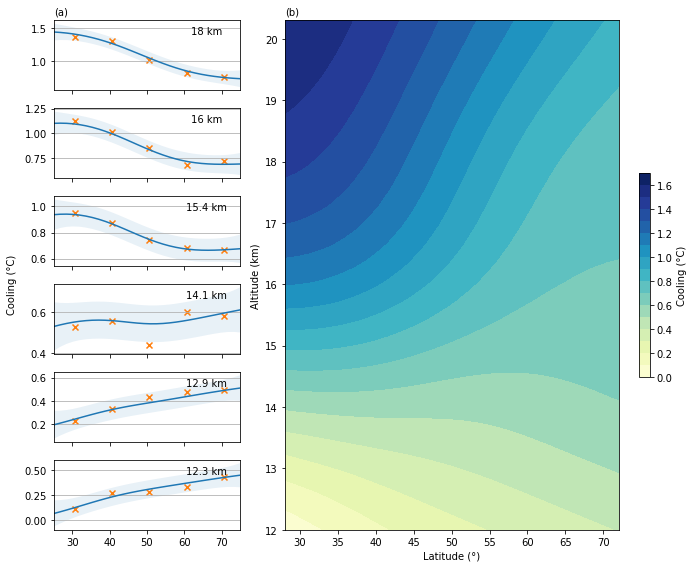

In [9]:
## repeat the altitude slice plot, but stacked vertically, and add a 2d view:
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(6, 3, figure=fig)

ax1 = fig.add_subplot(gs[:, 1:])
ax2, ax3, ax4 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[2, 0])
ax5, ax6, ax7 = fig.add_subplot(gs[3, 0]), fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[5, 0])

i=0
for ax in [ax2, ax3, ax4, ax5, ax6, ax7]:
    #altitude = DF['Injection_altitude'].sort_values().unique()[i]
    altitude = [18, 16, 15.4, 14.1, 12.9, 12.3][i]
    n_grid = 30
    Xplot1, Xplot2 = np.meshgrid(np.linspace(25, 75, n_grid), altitude*np.ones(n_grid))
    tests_13 = np.stack([Xplot1, Xplot2], axis=-1)
    y_mean, y_var = model.predict_y(tests_13[0], full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)
    ax.plot(np.linspace(25, 75, n_grid), y_mean)
    ax.fill_between(
        tests_13[0][:,0], y_lower[:, 0], y_upper[:, 0], alpha=0.1
    )
    data = DF[DF['Injection_altitude']==altitude]
    ax.scatter(data['Injection_latitude'], data[var], marker='x')
    ax.text(0.82, 0.84, str(np.round(altitude, 3))+' km',
             fontsize='medium',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
    #ax.set_title(str(np.round(altitude, 3))+' km')
    ax.set_xticklabels([])
    #ax.set_ylim([0, 1.6])
    #ax.set_yticks([0, 0.75, 1.5])
    ax.set_xlim([25, 75])
    ax.yaxis.grid()
    i=i+1
ax7.set_xticks([30, 40, 50, 60, 70])   
ax7.set_xticklabels([30, 40, 50, 60, 70])

#ax1.set_title('Large Plot')
n_grid = 30
Xplot1, Xplot2 = np.meshgrid(np.linspace(28, 72, n_grid), np.linspace(12, 21, n_grid))
Xplot = np.stack([Xplot1, Xplot2], axis=-1)
Xplot = Xplot.reshape([n_grid ** 2, 2])
f_mean, _ = model.predict_f(Xplot, full_cov=False)
f_mean = f_mean.numpy().reshape((n_grid, n_grid))
cf = ax1.contourf(Xplot1, Xplot2, f_mean, cmap='YlGnBu', levels=np.arange(0, 1.8, 0.1))
ax1.set_ylabel('Altitude (km)')
ax1.set_xlabel('Latitude (°)')
ax1.set_ylim(12, 20.3)
cbar = fig.colorbar(cf, ax=ax1, shrink=0.4)
cbar.ax.set_ylabel('Cooling (°C)')
ax1.set_title('(b)', fontsize='medium', loc='left')
ax2.set_title('(a)', fontsize='medium', loc='left')
fig.supylabel('Cooling (°C)', fontsize='medium')
#fig.suptitle('Cooling')
plt.tight_layout()
plt.savefig('Figures/Extra/GP_overview_{}.jpg'.format(var), dpi=300, bbox_inches='tight')
plt.show()

In [10]:
from matplotlib.gridspec import GridSpec

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

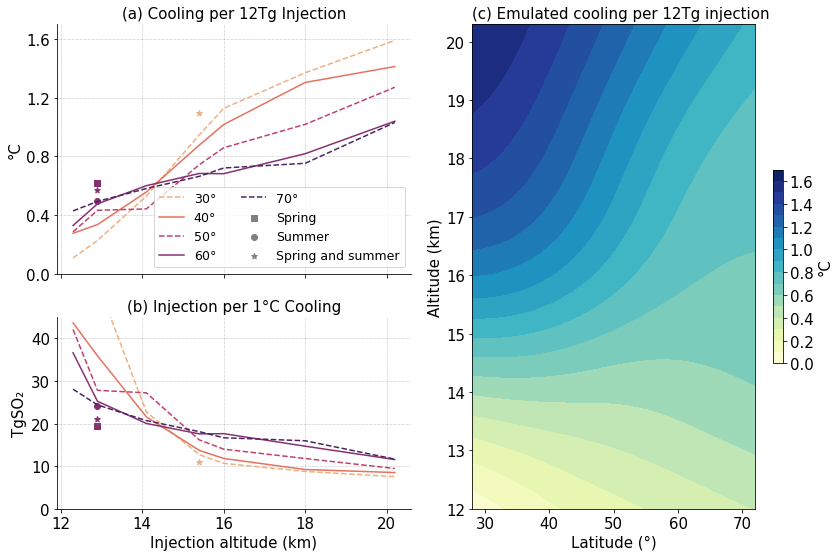

In [26]:
DF_Fs = pd.read_csv('Intermediate_outputs/TOA_forcings.csv') # made in 03
DF_s = DF_Fs[DF_Fs['Seasonal']=='Yes']

### now plot the estimated cooling and injection for 1C based on delta rsdscs:
# Set up GridSpec layout: 2 rows, 2 columns
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1.3, 1])

# Create subplots

ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left plot
ax1 = fig.add_subplot(gs[0, 0])  # Top-left plot
ax3 = fig.add_subplot(gs[:, 1])  # Right plot spanning both rows

#fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
cmap = sns.color_palette("flare", as_cmap=True)
palette = cmap(np.linspace(0, 1, len(DF['Injection_latitude'].unique())))
linestyles = ['--', 'solid', '--', 'solid', '--', 'solid']


ax = ax1
i=0
for injection_lat in DF['Injection_latitude'].unique():
    df_to_plot = DF[DF['Injection_latitude']==injection_lat]
    ax.plot(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
             #marker='x', 
             label=str(str(injection_lat).split('.')[0]+'°'),
             ls = linestyles[i],
             c = palette[i])
    i=i+1

ax.set_ylim(0, 1.7)
ax.set_ylabel('°C')
ax.set_title('(a) Cooling per 12Tg Injection', fontsize='medium')
ax.set_xticklabels([])
markers = ['s', 'o', '*']
i=0
for season in ['Spring', 'Summer']:
    df_to_plot = DF_s[DF_s['Seasonality']==season]
    ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[i], 
               #label=season,
               c = palette[3])
    i=i+1
df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==60.625]
ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[3])

ax.scatter([], [], marker=markers[0], label='Spring', c = 'gray')
ax.scatter([], [], marker=markers[1], label='Summer', c = 'gray')
ax.scatter([], [], marker=markers[2], label='Spring and summer', c = 'gray')

df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==30.625]
ax.scatter(df_to_plot['Injection_altitude'], df_to_plot['Cooling'], 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[0])
ax.legend(ncol=2, fontsize='small')
ax.set_yticks(np.arange(0, 1.8, 0.4))

ax = ax2
i=0
for injection_lat in DF['Injection_latitude'].unique():
    df_to_plot = DF[DF['Injection_latitude']==injection_lat]
    ax.plot(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
             #marker='x', 
             label=str(str(injection_lat).split('.')[0]+'°'),
             ls = linestyles[i],
             c = palette[i])
    i=i+1

i=0
for season in ['Spring', 'Summer']:
    df_to_plot = DF_s[DF_s['Seasonality']==season]
    ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[i], 
               label=season,
               c = palette[3])
    i=i+1
df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==60.625]
ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[2], 
               label='Spring and summer',
               c = palette[3])

df_to_plot = DF_s[DF_s['Seasonality']=='Mar-Aug/Sep-Feb']
df_to_plot = df_to_plot[df_to_plot['Injection_latitude']==30.625]
ax.scatter(df_to_plot['Injection_altitude'], 12/(df_to_plot['Cooling']), 
               marker=markers[2], 
               #label='Spring and summer',
               c = palette[0])
ax.set_ylim(0, 45)
ax.set_yticks(np.arange(0, 50, 10))
ax.set_ylabel('TgSO\u2082')   
ax.set_title('(b) Injection per 1°C Cooling', fontsize='medium')
ax.set_xlabel('Injection altitude (km)')

ax1.spines[['right', 'top']].set_visible(False)
ax1.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
ax2.spines[['right', 'top']].set_visible(False)
ax2.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)

cf = ax3.contourf(Xplot1, Xplot2, f_mean, cmap='YlGnBu', levels=np.arange(0, 1.8, 0.1))
ax3.set_ylabel('Altitude (km)')
ax3.set_xlabel('Latitude (°)')
ax3.set_ylim(12, 20.3)
cbar = fig.colorbar(cf, ax=ax3, shrink=0.4)
cbar.ax.set_ylabel('°C')
ax3.set_title('(c) Emulated cooling per 12Tg injection', fontsize='medium', loc='left')

plt.tight_layout()
fig.savefig('Figures/Main/Combined_cooling_summary.jpg', dpi=300, bbox_inches='tight')

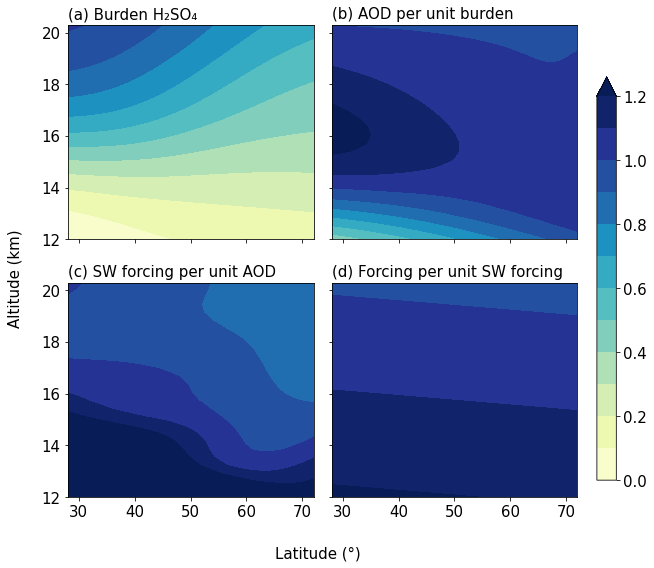

In [75]:
#### now read in the forcing variability decomp df, made seperately, and emulate these:
df_fv_full = pd.read_csv('Intermediate_outputs/Forcing_variability_decomp.csv').rename(columns={'Run':'Run_ID'})

# drop the seasonal runs
seasonal_runs = ['u-df848', 'u-df859', 'u-df931', 'u-df932', 
                 'u-dg051', 'u-dg331', 'u-dg381']
df_fv = df_fv_full[~df_fv_full['Run_ID'].isin(seasonal_runs)]

# drop any positive forcings:
df_fv = df_fv[df_fv['F']<0]
df_fv = df_fv[df_fv['SW_F']<0]

# also drop runs with AOD < y2y variability: 
AOD_y2ySTD = 0.0107
df_fv = df_fv[df_fv['aod']>AOD_y2ySTD]

DF_all = pd.merge(DF, df_fv, on='Run_ID', how='left')
#DF_all['Forcing_per_unit_AOD'] = DF_all['Delta_aerDirectForcing_SW']/(1-np.exp(-DF_all['delta_AOD']))

vars = ['burden_rel', 'aod_per_burden_rel', 'SW_F_per_aod_rel', 'F_per_SW_F_rel']


fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True, sharey=True)
vars = ['burden_rel', 'aod_per_burden_rel', 'SW_F_per_aod_rel', 'F_per_SW_F_rel']
labels = ['Burden H2SO4', 'AOD per unit burden', 'SW forcing per unit AOD', 'Forcing per unit SW forcing']
titles = ['(a) Burden H\u2082SO\u2084', '(b) AOD per unit burden', '(c) SW forcing per unit AOD', '(d) Forcing per unit SW forcing']
cmaps = ['YlGnBu', 'YlGnBu', 'YlGnBu', 'YlGnBu']
levels = np.arange(0, 1.25, 0.1)

i=0
for var in vars:
    inputs = DF_all.dropna(subset=var)[['Injection_latitude', 'Injection_altitude']].values
    outputs = DF_all.dropna(subset=var)[var].values.reshape(len(DF_all.dropna(subset=var)), 1)
    
    model = get_model(inputs, outputs)
    f_mean, _ = model.predict_f(Xplot, full_cov=False)
    f_mean = f_mean.numpy().reshape((n_grid, n_grid))

    ax = axs.flatten()[i]
    ax.set_xticks([30, 40, 50, 60, 70])   
    ax.set_xticklabels([30, 40, 50, 60, 70])
    cf = ax.contourf(Xplot1, Xplot2, f_mean, cmap=cmaps[i],
                    levels=levels,
                     extend='max')
        
    ax.set_ylim(12, 20.3)
    
    ax.set_title(titles[i], fontsize='medium', loc='left')
    i=i+1
    
fig.supylabel('Altitude (km)', fontsize='medium')
fig.supxlabel('Latitude (°)', fontsize='medium')
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax)

plt.savefig('Figures/Main/MainGP_forcing_decomp_v2.jpg'.format(var), dpi=300, bbox_inches='tight')
plt.show()

In [53]:
df_fv[df_fv['Run_ID']=='u-de567'] 

,Unnamed: 0,Run_ID,Burden,aod,SW_F,F,aod_per_burden,SW_F_per_aod,F_per_SW_F,burden_rel,aod_per_burden_rel,SW_F_per_aod_rel,F_per_SW_F_rel
22,22,u-de567,0.000001,0.031221,-0.763842,-0.595053,21895.28574,-24.465303,0.779027,0.180504,1.021196,1.128155,1.219524


In [54]:
df_fv[df_fv['Run_ID']=='u-de365']

,Unnamed: 0,Run_ID,Burden,aod,SW_F,F,aod_per_burden,SW_F_per_aod,F_per_SW_F,burden_rel,aod_per_burden_rel,SW_F_per_aod_rel,F_per_SW_F_rel
6,6,u-de365,0.000008,0.169378,-3.673155,-2.346395,21440.835439,-21.686121,0.638796,1.0,1.0,1.0,1.0


In [55]:
-0.595/-2.346

0.25362318840579706

In [56]:
0.29*0.64*1.13*1.22

0.25586815999999996

In [57]:
0.18*1.02*1.13*1.22

0.25311095999999994

In [58]:
df_fv_full[df_fv_full['Run_ID']=='u-dg331']

,Unnamed: 0,Run_ID,Burden,aod,SW_F,F,aod_per_burden,SW_F_per_aod,F_per_SW_F,burden_rel,aod_per_burden_rel,SW_F_per_aod_rel,F_per_SW_F_rel
40,40,u-dg331,0.000002,0.041715,-1.064779,-0.827377,23560.990807,-25.524782,0.777041,0.224124,1.098884,1.17701,1.216416


In [59]:
0.827/2.346

0.3525149190110827